In [1]:
import numpy as np

from jax import numpy as jp

from jax import jit,grad
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import cvxpy as cp

from RKHS import Gram

%load_ext autoreload
%autoreload 2

In [2]:
def h(r,c,l):
    return c * jp.exp(-(r**2) / l**2)

# The differentiable kernel function with parameters c,l not filled.

def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return h(jp.linalg.norm(x1-x2+small_sig,axis = -1),c,l)

In [3]:
def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,jp.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*jp.log(jp.linalg.det(np.eye(len(KA))+KA/var_0))
    else:
        return 1/2*jp.log(jp.linalg.det(KA))

In [11]:
def rand_u_search(x0,R,x_objective,T,step_size):
   
    def trajectory(x1,u):
        '''
        Generate x[1:T] given x[1] and u[1:T-1]
        '''
        return x1+np.cumsum(np.vstack([np.zeros(u.shape[-1]),u]),axis=0)

    objective = lambda x1,u: x_objective(trajectory(x1,u))
    uss = []
    vals = []
    for _ in range(50000):
        
        xs = [x0]
        us = []
        for i in range(T-1):
            
            cand_x = 0
            cand_u = 0
            while True:
                r = step_size

                theta = np.random.rand()*2*np.pi
                
                cand_u = r*np.array([np.cos(theta),np.sin(theta)])
                
                cand_x = xs[-1]+cand_u

                if np.linalg.norm(cand_x-x0)<=R:
                    break

            xs.append(cand_x)
            us.append(cand_u)

        us = np.array(us)
        val = objective(x0,us)
        
        uss.append(us)
        vals.append(val)
            
    return uss[np.argmax(vals)],np.max(vals),uss,vals

In [16]:
def projected_u_search(x_objective,x0,initial_us,ref,R,step_size):
    def trajectory(x1,u):
        '''
        Generate x[1:T] given x[1] and u[1:T-1]
        '''
        return x1+jp.cumsum(jp.vstack([np.zeros(u.shape[-1]),u]),axis=0)

    def project(x0,u,ref,R,step_size):
        # Setup the projection optimization problem

        z = x0+np.cumsum(np.vstack([np.zeros(u.shape[-1]),u]),axis=0)

        u_proj = cp.Variable(u.shape)

        z_proj = x0+cp.cumsum(cp.vstack([np.zeros(u.shape[-1]).reshape(1,-1),u_proj]),axis = 0)

        # Step size constraints
        constraints = [cp.norm(u_proj,axis=1)<=step_size] 

        # # Bounded search region constraints
        constraints += [cp.norm(z_proj[i]-ref[j])<=R[i,j] for i in range(T) for j in range(N)]

        prob = cp.Problem(cp.Minimize(cp.norm(z_proj-z)),constraints)

        prob.solve()

        return u_proj.value

    objective = jit(lambda x1,u: x_objective(trajectory(x1,u)))

    
    n_iter = 100
    delta_tolerance = 1e-7 # If ||z_{t+1}-z_t||<delta_tolerance, terminate the algorithm.
    eta = 0.01 # The learning rate for gradient update

    pg_us = []

    g = jit(grad(objective,argnums=[0,1]))

    for m,u_0 in enumerate(initial_us):

        print('{}th start outof {}.'.format(m,len(initial_us)))


        # z_0 = np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size # set z_0 to be the straight line

        u = np.array(u_0)

        best_u = u_0
        best_val = objective(x0,u_0)

        for _ in range(n_iter):
            dx1,du=g(x0,u)
            u += eta * du # Gradient step
            u = project(x0,u,ref,R,step_size) # Projection

 
            if objective(x0,u)> best_val:
                best_u = u
                best_val = objective(x0,u)

        pg_us.append(best_u)
        
    ob = [objective(x0,u) for u in pg_us]

    return np.array(trajectory(x0,pg_us[np.argmax(ob)]))

In [5]:

T = 19

c = 1
l = 1
var_0 = 0.01

x_objective = lambda z: GPMI(z,c=c,l=l,var_0=var_0)


search_region_center = np.array([0.,0.])
search_region_radius = 3
step_size = 1

kernel = partial(k,c=c,l=l)

In [6]:

# The reference system.
ref = np.array([[0,0]]) # A single point reference set.
R = np.array([search_region_radius*np.ones(T)]).T
R[0,0] = 0

N = len(ref)


# Random search I

**No** bounded search region constraint.

Fix $||x_t-x_{t-1}||=D$, and search using random direction.

$$
    x_t\gets x_{t-1} + D * \text{ random unit vector}
$$


In [ ]:
x0 = search_region_center

In [12]:
_,_,uss,vals = rand_u_search(x0,\
                         search_region_radius,x_objective,T,step_size)

In [13]:
top_n = 1

top_us = np.array(uss)[np.argsort(vals)[-top_n:]]

# Projected Gradient in $u=u_{1:T}$

In [18]:
projected_u_search(x_objective,x0,top_us,ref,R,step_size)

0th start outof 1.


array([[ 0.        ,  0.        ],
       [ 0.9197333 ,  0.39234003],
       [ 0.9620446 ,  1.3912492 ],
       [ 0.7461325 ,  2.3675327 ],
       [-0.14832133,  1.9189612 ],
       [-0.9387002 ,  2.5313797 ],
       [-1.472451  ,  1.6858947 ],
       [-2.2436662 ,  1.0495533 ],
       [-2.9232745 ,  0.31634772],
       [-2.8328316 , -0.6797664 ],
       [-2.0076373 , -0.1300723 ],
       [-1.4177296 ,  0.6724167 ],
       [-1.2967728 , -0.32000637],
       [-0.6257204 , -1.0612742 ],
       [-1.2676789 , -1.828351  ],
       [-0.9240104 , -2.7672462 ],
       [ 0.06995517, -2.6874943 ],
       [ 0.5975741 , -1.8387892 ],
       [ 1.3322766 , -2.519282  ]], dtype=float32)

# Solve for the upper bound under the bounded region constraint
Given reference points $a_{1:N}$, inducing $A = [k(a_i,a_j)]$.

The ultimate problem we attempt to solve is,

$$
		\max_{x_1,x_2,...,x_{T}} F(x_{1:T})\\
        ~||x_{t+1}-x_t||\leq D,~\forall t=1,...,T-1\\
		~ ||x_t-a_k||\leq R_{t,k},~\forall 1\leq t \leq T,~1\leq k\leq N
$$

where $R_{t,k}$ are pre-specified distance bounds to the reference points. 

The convex relaxation of the above we consider hereafter is
$$
    \max_{\Sigma,B}~\log\det(I+\Sigma/\sigma^2)\\
		s.t.~M=\begin{bmatrix}
    \Sigma & B\\
B^\top & A
\end{bmatrix}\succ 0\\
~\Sigma_{ii}=c,\forall i=1,2,...,T\\
~\Sigma_{i,i+1}\geq d,\forall i=1,...,T-1\\
~B_{ik}\geq b_{ik}=h(R_{i,k}),\forall i,k\\
(\text{Without admissibility constraints})
$$

Very often we want to impose the constraint that the initial location $x_1$ is fixed, this can be achieve by specifying the desired initial location as the value of $a_1$ and impose $||x_1-a_1||\leq 0$, or $b_{11} = h(0)$.

The optimal value of the convex relaxation is an upper bound on the ultimate problem, which could be loose.


In [14]:

d = h(step_size,c=c,l=l)

A = Gram(kernel,ref)

N = len(A)


b = np.ones((T,N))*np.array(h(R,c=c,l=l))
b[0,0] = h(0,c=c,l=l) # Initial location constraint.

In [15]:
# Define and solve the problem
B = cp.Variable((T,N))

S = cp.Variable((T,T),symmetric=True)

M = cp.vstack([cp.hstack([S,B]),
               cp.hstack([B.T,A])])


constraints = [M>>0]


constraints += [cp.diag(S)==c]

constraints += [S[i,i+1]>=d for i in range(0,T-2)]

constraints += [B>=b]



prob = cp.Problem(cp.Maximize(1/2*cp.log_det(np.eye(T)+ S/var_0)),constraints)

upper_bound = prob.solve()

In [16]:
upper_bound

42.6337958180866

# Honeycomb lattice in 2D

A equi-distance honeycomb lattice with $k$ layers has $6k^2+1$ vertices.

If there are $T$ vertices, we need $L = \lceil \sqrt{\frac{T-1}{6}} \rceil$ layers.

Fitting these $L$ layers into a ball with radius $R$, the distance between two neighboring vertices in the lattice is at most $R/L$.

In [17]:
from Lattice import honeycomb

In [18]:
N_layer = int(np.ceil(np.sqrt((T-1)/6)))+1

hive=honeycomb(np.min([search_region_radius,(N_layer-1)*step_size]),N_layer)

# Equi-angular placement

In [19]:
thetas = np.linspace(0,2*np.pi,T+1)[:-1]
equi_angle = search_region_center.reshape(-1,1)+search_region_radius*np.array([np.cos(thetas),np.sin(thetas)])
equi_angle = np.vstack([equi_angle.T])

# Compare the solutions and the upper bound

In [47]:
sols = {
    'Random Brute Force':  np.array(trajectory(search_region_center,top_us[-1])),
        'Equi-Angle': equi_angle,
    'Honeycomb':hive,
#         'Straight Line': np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size,
        'PG-BruteInit': np.array(trajectory(search_region_center,best_u)),
#     'PG-EquiInit':best_z_equi,
#     'PG-HiveInit':best_z_hive,
       }
alphas = {
    'Random Brute Force': 0.5,
       'Equi-Angle': 1,
        'Honeycomb':1,
#         'Straight Line': 0.5,
        'PG-BruteInit': 1,
    'PG-EquiInit':1,
    'PG-HiveInit':1,
       } 
colors = {
    'Random Brute Force': 'grey',
     'Equi-Angle': 'blue',
    'Honeycomb':'orange',
#         'Straight Line': 'orange',
        'PG-BruteInit': 'green',
        'PG-EquiInit':'purple',
    'PG-HiveInit':'red',
       } 


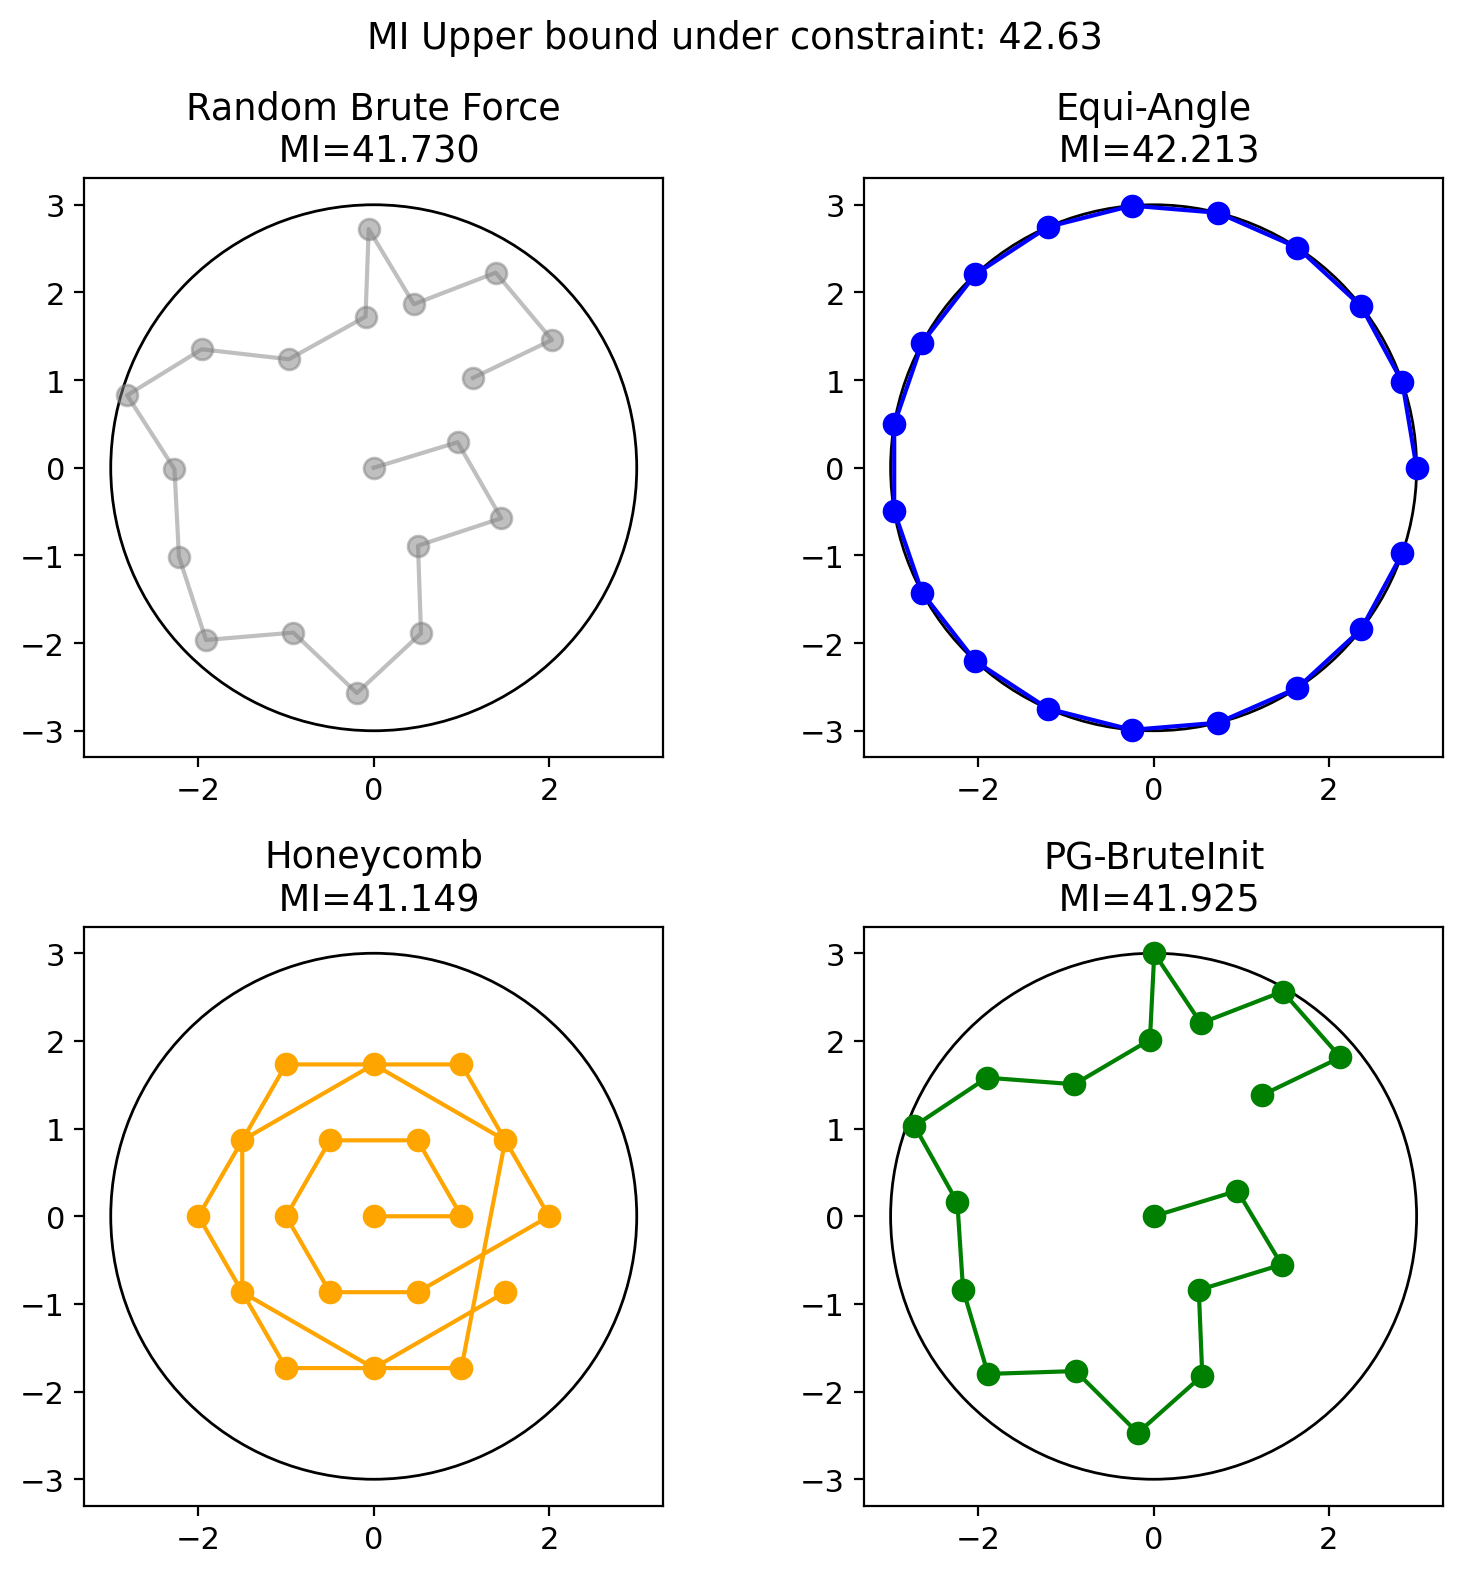

In [48]:

plt.rc('font',size=11)
fig,axes = plt.subplots(2,2,dpi=200,figsize=(8,8))

axes = axes.flatten()

for m,(key,val) in enumerate(sols.items()):
    ax = axes[m]
 
    ax.plot(val[:,0],val[:,1],marker = '.',markersize = 15,\
             alpha = alphas[key],
            color = colors[key])
    
    ax.set_aspect('equal')

    circ = plt.Circle(search_region_center,search_region_radius,fill=False)
    ax.add_patch(circ)
    ax.set_title("{}\n MI={:.3f}".format(key,x_objective(val)))
    
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.suptitle('MI Upper bound under constraint: {:.2f}'.format(upper_bound))

plt.tight_layout()
plt.show()